### `---------------Mandatory Information to fill------------`

### Group ID: Group 278
### Group Members Name with Student ID:
1. Rahul Prashar - 2024AB05058 - 100%
2. Rahul Agarwal - 2024AA05676 - 100%
3. Rahul Sinha - 2024AA05036 - 100%
4. Raghavendra Sathakarni A S - 2024AB05118 - 100%


## Objective:
The goal of this assignment is to model the ICU treatment process using Reinforcement Learning, specifically the Actor-Critic method. The agent should learn an optimal intervention policy from historical ICU data. Each patient's ICU stay is treated as an episode consisting of time-stamped clinical observations and treatments.
Your tasks:
1.	Model the ICU treatment process as a Reinforcement Learning (RL) environment.
2.	Train an Actor-Critic agent to suggest medical interventions based on the patient’s current state (vitals and demographics).





## Dataset:

Use the dataset provided in the following link:

https://drive.google.com/file/d/1UPsOhUvyrsrC59ilXsvHwGZhzm7Yk01w/view?usp=sharing

**Features:**

•	*Vitals*: mean_bp, spo2, resp_rate

•	*Demographics*: age, gender

•	*Action*: Medical intervention (e.g., "Vancomycin", "NaCl 0.9%", or NO_ACTION)

•	*Identifiers*: timestamp, subject_id, hadm_id, icustay_id


## State Space :

Each state vector consists of: mean_bp (Mean Blood Pressure) , spo2 (Oxygen Saturation), resp_rate (Respiratory Rate), age, One-hot encoded gender


## Action Space :

•	The agent selects one discrete action from 99 possible medical interventions (e.g., Vancomycin, Fentanyl, PO Intake, etc.

•	You should integer encode or one-hot encode these interventions.



## Reward Function:

At each time step, the agent receives a reward based on how close the patient's vitals are to clinically normal ranges. The reward encourages the agent to take actions that stabilize the patient's vital signs:

$$
\text{Reward}_t = - \left( (MBP_t - 90)^2 + (SpO2_t - 98)^2 + (RR_t - 16)^2 \right)
$$


**Explanation:**

•	MBP (mean_bp): Target = 90 mmHg

•	SpO₂ (spo2): Target = 98%

•	RR (resp_rate): Target = 16 breaths/min

Each term penalizes the squared deviation from the healthy target. The smaller the difference, the higher (less negative) the reward.

**Example:**

Suppose at time t, the vitals are:

•	MBP = 88

•	SpO₂ = 97

•	RR = 20

Then the reward is:

$$
\text{Reward}_t = - \left[ (88 - 90)^2 + (97 - 98)^2 + (20 - 16)^2 \right] = - (4 + 1 + 16) = -21
$$


*A lower (more negative) reward indicates worse vitals, guiding the agent to learn actions that minimize this penalty.*





### 📍 Episode Termination

An episode ends when the ICU stay ends. To define this:

1. **Group the data** by `subject_id`, `hadm_id`, and `icustay_id`  
   → Each group represents one ICU stay = one episode.

2. **Sort each group** by `timestamp`  
   → Ensures the time progression is correct.

3. **For each time step** in a group (i.e., each row):  
   → Check if it is the **last row** in that group.  
   &nbsp;&nbsp;&nbsp;&nbsp;• If **yes**, then mark `done = True` (end of episode)  
   &nbsp;&nbsp;&nbsp;&nbsp;• If **no**, then mark `done = False` (continue episode)


## Requirements and Deliverables:

Implement the Sepsis
Treatment Optimization Problem for the given above scenario for the below mentioned RL method.

### Initialize constants

In [2]:
# Initialize contstants
GAMMA = 0.9            # Discount factor for future rewards
LR = 5e-4              # Learning rate for Adam optimizer
N_EPISODES = 1000      # Number of episodes for training (ICU stays)
STATE_DIM = 6          # Dimension of state vector (including one-hot gender)
ENTROPY_BETA = 0.009   # Typical values: 0.001 – 0.02


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Import
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# Use gymnasium instead of gym
import gymnasium as gym
from gymnasium import spaces

print('python:', os.sys.version.split('\n')[0])
print('torch:', getattr(torch, '__version__', 'not installed'))
print('gymnasium:', gym.__version__)

python: 3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]
torch: 2.6.0+cu124
gymnasium: 1.2.0


### Load Dataset    (0.5 Mark)

In [4]:
# Code for Dataset loading and preprocessing

# Load dataset
df = pd.read_csv('/content/drive/MyDrive/deep-learning-projects/deep_reinforcement_learning/ASSIGNMENT_2/Sepsis_datset.csv')

# Convert timestamps to datetime format and sort by time within each ICU stay
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values(['subject_id', 'hadm_id', 'icustay_id', 'timestamp'])

# One-hot encode gender
gender_ohe = pd.get_dummies(df['gender'], prefix='gender')
df = pd.concat([df.drop(columns=['gender']), gender_ohe], axis=1)

# Integer encode actions
action_le = LabelEncoder()
df['action_encoded'] = action_le.fit_transform(df['action'])
NUM_ACTIONS = len(df['action'].unique())


In [7]:
df.head()

,subject_id,hadm_id,icustay_id,timestamp,mean_bp,spo2,resp_rate,age,action,gender_F,gender_M,action_encoded
0,40124,126179,279554,2130-02-04 04:42:00,101,100,15,67,NO_ACTION,True,False,68
1,40124,126179,279554,2130-02-04 05:00:00,78,100,15,67,NO_ACTION,True,False,68
2,40124,126179,279554,2130-02-04 05:01:00,78,100,15,67,NO_ACTION,True,False,68
3,40124,126179,279554,2130-02-04 05:03:00,78,99,15,67,NO_ACTION,True,False,68
4,40124,126179,279554,2130-02-04 06:00:00,63,100,17,67,NO_ACTION,True,False,68


### Design a SepsisTreatmentEnv Environment (0.5 Mark)

In [8]:
# Code for environment creation
class SepsisTreatmentEnv(gym.Env):
    def __init__(self, data):
        super().__init__()
        self.data = data
        self.groups = list(data.groupby(['subject_id', 'hadm_id', 'icustay_id']))
        self.observation_space = spaces.Box(
            low=np.array([0,0,0,0,0]),
            high=np.array([300,100,60,120,1]), dtype=np.float32)
        self.action_space = spaces.Discrete(NUM_ACTIONS)
        self.current_episode = None
        self.current_step = 0

    def reset(self):
        self.current_episode_idx = np.random.randint(len(self.groups))
        _, self.current_episode = self.groups[self.current_episode_idx]
        self.current_episode = self.current_episode.reset_index(drop=True)
        self.current_step = 0
        return self._get_state(self.current_step)

    def _get_state(self, step):
      row = self.current_episode.loc[step]
      return np.array([
        row['mean_bp'],
        row['spo2'],
        row['resp_rate'],
        row['age'],
        row['gender_F'],  # one-hot gender column for Female
        row['gender_M']   # one-hot gender column for Male
      ], dtype=np.float32)

    def step(self, action):
        row = self.current_episode.loc[self.current_step]
        reward = Reward(row['mean_bp'], row['spo2'], row['resp_rate'])
        done = self.current_step == len(self.current_episode) - 1
        self.current_step += 1 if not done else 0
        next_state = self._get_state(self.current_step) if not done else None
        return next_state, reward, done, {}


### Implement the Reward Function  (1 Mark)

In [9]:
# Code for reward function
def Reward(mean_bp, spo2, resp_rate):
    """
    Reward(t) = - [(mean_bp-90)^2 + (spo2-98)^2 + (resp_rate-16)^2]
    Penalizes deviation from normal vitals.
    """
    return -((mean_bp - 90) ** 2 + (spo2 - 98) ** 2 + (resp_rate - 16) ** 2)

example_row = df.iloc[0]
print(f"Example Reward: {Reward(example_row['mean_bp'], example_row['spo2'], example_row['resp_rate']):.2f}")


Example Reward: -126.00


### Design and train Actor-Critic Algorithm  (2.5 Mark)


In [10]:
# Code for training
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(state_dim, 128), nn.LeakyReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 128), nn.LeakyReLU(),
            nn.Linear(128, action_dim),
            nn.Softmax(dim=-1)
        )
    def forward(self, x):
        return self.fc(x)

class Critic(nn.Module):
    def __init__(self, state_dim):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(state_dim, 128), nn.LeakyReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 128), nn.LeakyReLU(),
            nn.Linear(128, 1)
        )
    def forward(self, x):
        return self.fc(x)

def train_actor_critic(episodes=N_EPISODES, gamma=GAMMA):
  env = SepsisTreatmentEnv(df)
  actor = Actor(STATE_DIM, NUM_ACTIONS)
  critic = Critic(STATE_DIM)
  optimizerA = optim.Adam(actor.parameters(), lr=LR)
  optimizerC = optim.Adam(critic.parameters(), lr=LR)

  rewards_history = []
  episode_lengths = []


  for episode in range(N_EPISODES):
    state = env.reset()
    done = False
    ep_reward = 0
    steps = 0
    while not done:
        # 1. Convert current state into tensor for the networks
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)

        # 2. Actor selects an action (stochastic policy via categorical distribution)
        probs = actor(state_tensor)
        dist = torch.distributions.Categorical(probs)
        action = dist.sample().item()
        entropy = dist.entropy()

        # 3. Take action in environment → observe next_state, reward, termination flags
        next_state, reward, done, _ = env.step(action)
        ep_reward += reward
        steps += 1

        # 4. Critic evaluates current state value and next state value (bootstrap if not done)
        value = critic(state_tensor)
        next_value = critic(torch.tensor(next_state, dtype=torch.float32).unsqueeze(0)) if not done else torch.zeros(1)

        # 5. Compute target return for critic using reward + discounted next value
        target = torch.tensor(reward + GAMMA * next_value.item())

        # 6. Critic loss = MSE between predicted value and target
        critic_loss = (target - value).pow(2).mean()

        # 7. Actor loss = -(log_prob * advantage) - entropy_bonus
        log_prob = torch.log(probs.squeeze(0)[action])
        advantage = (target - value).detach()
        actor_loss = - (log_prob * advantage) - (ENTROPY_BETA * entropy)

        # 8. Backprop: update Actor
        optimizerA.zero_grad()
        actor_loss.backward()
        optimizerA.step()

        # 9. Backprop: update Critic
        optimizerC.zero_grad()
        critic_loss.backward()
        optimizerC.step()

        # 10. Transition to the next state
        state = next_state

    # Track episode reward and episode length
    rewards_history.append(ep_reward)
    episode_lengths.append(steps)

    # Print progress every 50 episodes
    if (episode+1) % 5 == 0:
      print(f"Episode {episode+1} | Reward: {ep_reward:.2f} | Length: {steps}")


  # Training code
  return actor, critic, rewards_history, episode_lengths

### Plot the graph for Average Reward   (1 Mark)

Episode 5 | Reward: -16493.00 | Length: 89
Episode 10 | Reward: -9989.00 | Length: 35
Episode 15 | Reward: -73213.00 | Length: 37
Episode 20 | Reward: -33474.00 | Length: 36
Episode 25 | Reward: -8524.00 | Length: 33
Episode 30 | Reward: -11900.00 | Length: 47
Episode 35 | Reward: -274944.00 | Length: 313
Episode 40 | Reward: -22262.00 | Length: 42
Episode 45 | Reward: -8254.00 | Length: 32
Episode 50 | Reward: -227612.00 | Length: 334
Episode 55 | Reward: -21073.00 | Length: 86
Episode 60 | Reward: -65670.00 | Length: 75
Episode 65 | Reward: -20499.00 | Length: 50
Episode 70 | Reward: -4087.00 | Length: 19
Episode 75 | Reward: -3388.00 | Length: 24
Episode 80 | Reward: -73213.00 | Length: 37
Episode 85 | Reward: -9689.00 | Length: 28
Episode 90 | Reward: -16645.00 | Length: 27
Episode 95 | Reward: -274944.00 | Length: 313
Episode 100 | Reward: -76056.00 | Length: 119
Episode 105 | Reward: -54933.00 | Length: 58
Episode 110 | Reward: -5439.00 | Length: 26
Episode 115 | Reward: -116868.

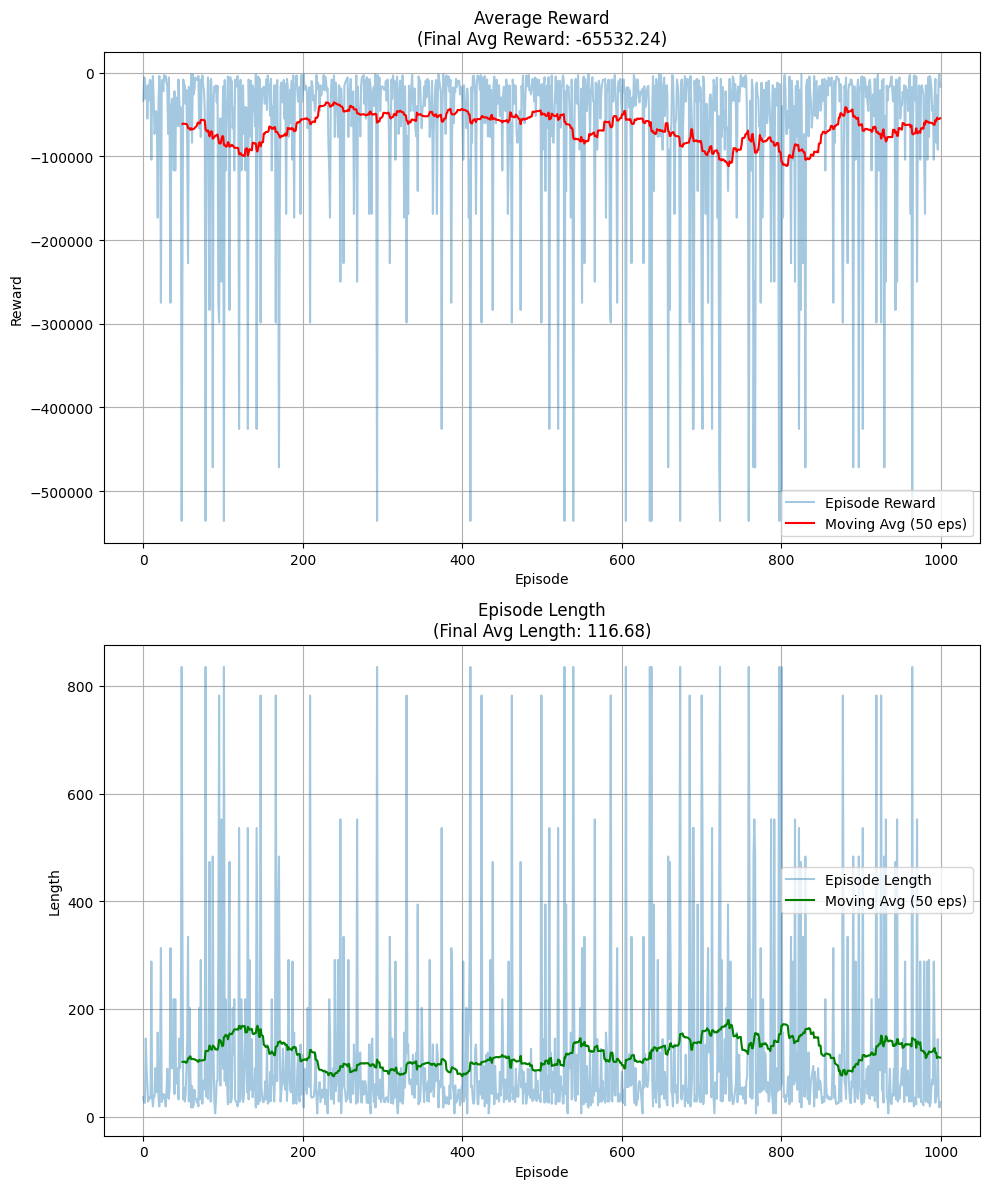

<Figure size 640x480 with 0 Axes>

In [11]:
# Code for plotting the average reward
def plot_training_curves(rewards, lengths, reward_window=50, length_window=50):
    fig, axes = plt.subplots(2, 1, figsize=(10, 12))

    # Reward plot (left)
    axes[0].plot(rewards, label="Episode Reward", alpha=0.4)
    if len(rewards) >= reward_window:
        reward_ma = np.convolve(rewards, np.ones(reward_window)/reward_window, mode='valid')
        axes[0].plot(range(reward_window-1, len(rewards)), reward_ma, label=f"Moving Avg ({reward_window} eps)", color='red')
    avg_reward_total = np.mean(rewards)
    axes[0].set_xlabel("Episode")
    axes[0].set_ylabel("Reward")
    axes[0].set_title(f"Average Reward\n(Final Avg Reward: {avg_reward_total:.2f})")
    axes[0].legend()
    axes[0].grid(True)

    # Length plot (right)
    axes[1].plot(lengths, label="Episode Length", alpha=0.4)
    if len(lengths) >= length_window:
        length_ma = np.convolve(lengths, np.ones(length_window)/length_window, mode='valid')
        axes[1].plot(range(length_window-1, len(lengths)), length_ma, label=f"Moving Avg ({length_window} eps)", color='green')
    avg_length_total = np.mean(lengths)
    axes[1].set_xlabel("Episode")
    axes[1].set_ylabel("Length")
    axes[1].set_title(f"Episode Length\n(Final Avg Length: {avg_length_total:.2f})")
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()
    plt.savefig('training_curves.png', bbox_inches='tight')


# Usage after training:
actor, critic, rewards, lengths = train_actor_critic()
plot_training_curves(rewards, lengths)


<br>
<br>

### **Provide a 200-word writeup on the behavior, reward trends, and stability of the trained policy**	  (0.5 Mark)


From the learning curves and episodic logs, the policy shows high variance in both rewards and episode lengths, with repeated sharp spikes and collapses. Rewards remain consistently negative across training, ranging from moderate penalties (−3k to −20k) to catastrophic values (−200k to −500k). This suggests that the environment strongly penalizes certain trajectories, and the agent has not yet stabilized its exploration–exploitation balance.

The moving averages smooth some of this volatility, but even long windows reveal no clear upward trend toward less negative rewards. Instead, the agent oscillates between short episodes with small penalties and long, unstable rollouts with extremely poor returns. This instability is also reflected in episode lengths, which range from very short (6–30 steps) to extremely long (>800 steps), indicating inconsistent policy execution.

Hyperparameter choices may contribute: the discount factor γ=0.9 prioritizes short-term outcomes, which can discourage long-horizon optimization. The entropy bonus (β=0.009) may be sustaining excessive exploration, preventing convergence. Learning rate (5e−4) is within typical ranges but might be too high for such a volatile environment.

In summary, the policy is not yet stable. While it sometimes discovers short, lower-penalty trajectories, it frequently collapses into catastrophic failures. Adjusting entropy regularization, tuning γ, or increasing training episodes may improve stability.